
# **Assignment 2 - Applying Covents to image data**

### Downloading the data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ankithdasu","key":"a1d432fd1633e487d19a2e2a42b4c0d3"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:35<00:00, 25.1MB/s]
100% 812M/812M [00:35<00:00, 24.0MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [18]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)



***************************************************************************


# **Training the convent network from scratch**

 **Model 1) Training sample of 1000, a validation sample of 500, and a test sample of 500**


In [14]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Epoch 1/50
63/63 [==============================] - 15s 86ms/step - loss: 0.7224 - accuracy: 0.5000 - val_loss: 0.6902 - val_accuracy: 0.5020
Epoch 2/50
63/63 [==============================] - 5s 75ms/step - loss: 0.7024 - accuracy: 0.5470 - val_loss: 0.6484 - val_accuracy: 0.6290
Epoch 3/50
63/63 [==============================] - 5s 76ms/step - loss: 0.6892 - accuracy: 0.5915 - val_loss: 0.6382 - val_accuracy: 0.6300
Epoch 4/50
63/63 [==============================] - 6s 85ms/step - loss: 0.6241 - accuracy: 0.6605 - val_loss: 1.0186 - val_accuracy: 0.5170
Epoch 5/50
63/63 [==============================] - 5s 74ms/step - loss: 0.6032 - accuracy: 0.6800 - val_loss: 0.6152 - val_accuracy: 0.6580
Epoch 6/50
63/63 [==============================] - 5s 74ms/step - loss: 0.5893 - accuracy: 0.6970 - val_loss: 0.8221 - val_accuracy: 0.5650
Epoch 7/50
63/63 [==============================] - 5s 73ms/step - loss: 0.5516 - accuracy: 0.7195 - val_loss: 0.7481 - val_accuracy: 0.6470
Epoch 8/50
6

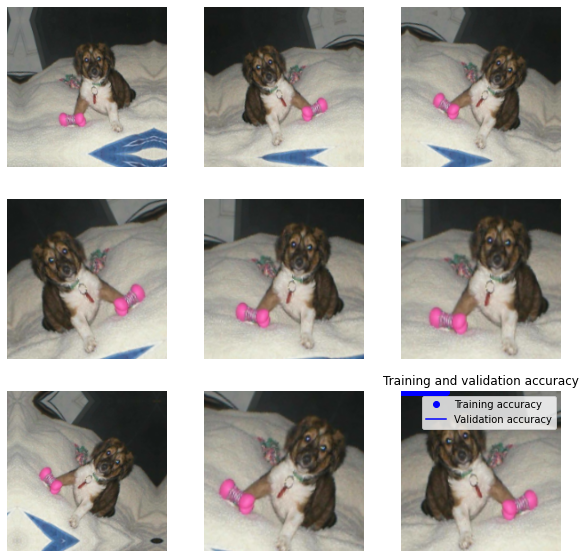

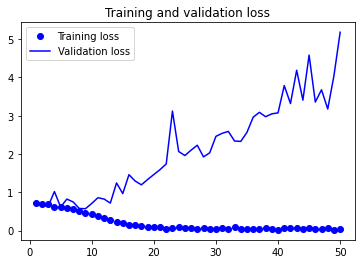

32/32 [==============================] - 2s 40ms/step - loss: 0.5756 - accuracy: 0.7160
Test accuracy: 0.716


In [9]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True, 
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)




accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()



test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")



******************************************************************************

**Model 2 - Increasing training sample and keeping same validation sample of 1000, and a test sample of 1000.**


In [9]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train_2", start_index=0, end_index=3000)
make_subset("validation_2", start_index=3000, end_index=3500)
make_subset("test_2", start_index=3500, end_index=4000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_2",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_2",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_2",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Epoch 1/50
188/188 [==============================] - 14s 60ms/step - loss: 0.8333 - accuracy: 0.5497 - val_loss: 0.6851 - val_accuracy: 0.5330
Epoch 2/50
188/188 [==============================] - 11s 58ms/step - loss: 0.6779 - accuracy: 0.6080 - val_loss: 0.6352 - val_accuracy: 0.6300
Epoch 3/50
188/188 [==============================] - 11s 58ms/step - loss: 0.6459 - accuracy: 0.6527 - val_loss: 0.6056 - val_accuracy: 0.6760
Epoch 4/50
188/188 [==============================] - 11s 57ms/step - loss: 0.6229 - accuracy: 0.6695 - val_loss: 0.5909 - val_accuracy: 0.6840
Epoch 5/50
188/188 [==============================] - 11s 57ms/step - loss: 0.5990 - accuracy: 0.7005 - val_loss: 0.5785 - val_accuracy: 0.7010
Epoch 6/50
188/188 [==============================] - 11s 58ms/step - loss: 0.5774 - accuracy: 0.7152 - val_loss: 0.5494 - val_accuracy: 0.7230
Epoch 7/50
188/188 [==============================] - 15s 77ms/step - loss: 0.5479 - accuracy: 0.7317 - val_loss: 0.5518 - val_accuracy:

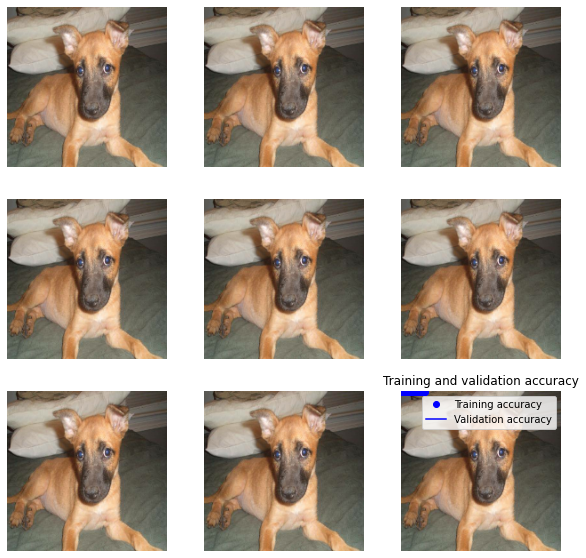

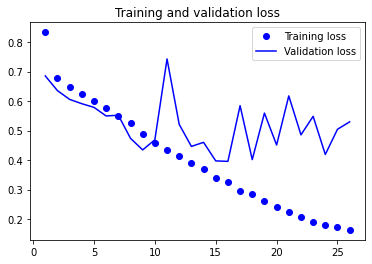

32/32 [==============================] - 2s 37ms/step - loss: 0.4648 - accuracy: 0.8100
Test accuracy: 0.810


In [11]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)




accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()



test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")



*****************************************************************************************

**Model 3 - Again increasing the training sample size and keeping same validation sample of 1000, and a test sample of 1000.**


In [19]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train_3", start_index=0, end_index=10000)
make_subset("validation_3", start_index=10000, end_index=10500)
make_subset("test_3", start_index=10500, end_index=11000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_3",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_3",
    image_size=(180, 180),
    batch_size=32)

Found 20000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Epoch 1/50
625/625 [==============================] - 34s 53ms/step - loss: 0.7023 - accuracy: 0.6069 - val_loss: 0.5843 - val_accuracy: 0.7080
Epoch 2/50
625/625 [==============================] - 34s 54ms/step - loss: 0.5641 - accuracy: 0.7286 - val_loss: 0.5199 - val_accuracy: 0.7510
Epoch 3/50
625/625 [==============================] - 37s 58ms/step - loss: 0.4922 - accuracy: 0.7824 - val_loss: 0.4412 - val_accuracy: 0.8140
Epoch 4/50
625/625 [==============================] - 33s 52ms/step - loss: 0.4355 - accuracy: 0.8150 - val_loss: 0.4720 - val_accuracy: 0.7860
Epoch 5/50
625/625 [==============================] - 33s 52ms/step - loss: 0.3905 - accuracy: 0.8403 - val_loss: 0.3623 - val_accuracy: 0.8450
Epoch 6/50
625/625 [==============================] - 33s 52ms/step - loss: 0.3547 - accuracy: 0.8602 - val_loss: 0.3823 - val_accuracy: 0.8290
Epoch 7/50
625/625 [==============================] - 33s 52ms/step - loss: 0.3281 - accuracy: 0.8744 - val_loss: 0.3581 - val_accuracy:

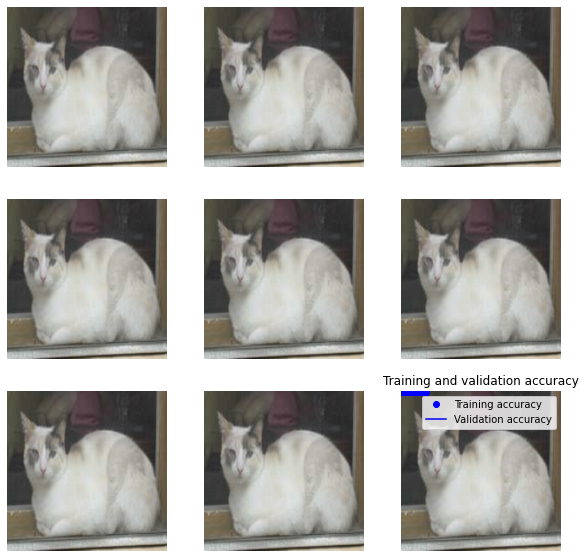

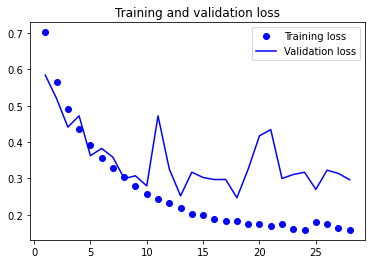

32/32 [==============================] - 3s 62ms/step - loss: 0.3003 - accuracy: 0.9070
Test accuracy: 0.907


In [13]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)




accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()



test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

**VGG16 Pretrained Convnet Network**

**Pretrained Model-1 - Training sample of 2000, a validation sample of 1000, and a test sample of 1000.**



**Using Feature Extraction with Data Augmentation and Fine-tuning**

Epoch 1/50
63/63 [==============================] - 5s 74ms/step - loss: 0.0806 - accuracy: 0.9850 - val_loss: 0.1306 - val_accuracy: 0.9690
Epoch 2/50
63/63 [==============================] - 5s 72ms/step - loss: 0.0620 - accuracy: 0.9900 - val_loss: 0.1765 - val_accuracy: 0.9540
Epoch 3/50
63/63 [==============================] - 5s 73ms/step - loss: 0.2128 - accuracy: 0.9830 - val_loss: 0.1880 - val_accuracy: 0.9570
Epoch 4/50
63/63 [==============================] - 5s 73ms/step - loss: 0.1527 - accuracy: 0.9725 - val_loss: 0.3298 - val_accuracy: 0.9340
Epoch 5/50
63/63 [==============================] - 5s 74ms/step - loss: 0.0989 - accuracy: 0.9795 - val_loss: 0.1299 - val_accuracy: 0.9610
Epoch 6/50
63/63 [==============================] - 5s 73ms/step - loss: 0.1023 - accuracy: 0.9800 - val_loss: 0.1148 - val_accuracy: 0.9670
Epoch 7/50
63/63 [==============================] - 5s 73ms/step - loss: 0.0900 - accuracy: 0.9845 - val_loss: 0.2075 - val_accuracy: 0.9470
Epoch 8/50
63

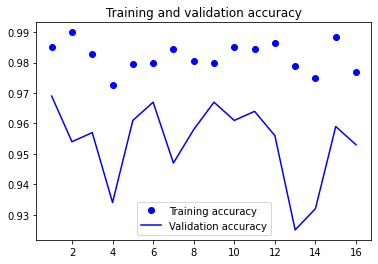

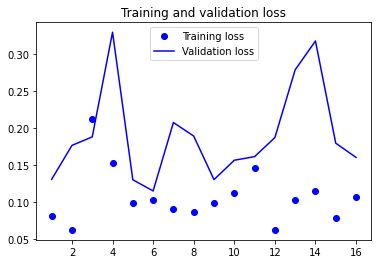

32/32 [==============================] - 2s 35ms/step - loss: 0.1622 - accuracy: 0.9600
Test accuracy: 0.960


In [16]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Instantiating the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_1 = keras.Model(inputs, outputs)
# Fine-tuning the model
model_pre_trained_1.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)



# Plotting the results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")




## Summary

**My Interpretations and Recommendations:**

I want to highlight few things which has improved the model and also which can improve the model.

1) Fine-tuning, as the name suggested was pretty much effective in getting the best accuracy using with dropout and data augmentation. It is a technique that applies some of the representations which are already learnt by an existing model to a new challenge as a additional to feature extraction. This raises the bar for performance. \linebreak


2) One interesting thing I have tried is **Colour Augmentation** while i was looking for some articles on types of Data Augmentation. We can improve Brightness, Contrast or Saturation using this. I feel this can be used for classification of some legacy pictures. \linebreak

3) Also, While running the high training sample around 6000, each Epoch has taken 61 s and model with 10,000 samples has taken 64seconds. 
If there is proper infra(GPU), then i think this can be handled. \linebreak

4) Using optimisers effectively and increasing the sample size has actually improved the accuracy. 

**Miscellaneous**:
I have tried **'NVIDIA Deep Learning GPU Training System (DIGITS)'** with the current dataset for classifying the images.
This tool comes with a license cost but i was able to try the classification for certain samples. 
I have noticed that, it had a effective model designed within along with best optimisation techniques embedded in it. The time for processing was very less and the accuracy claimed by them was 98% in the market. I suggest other peers to try this tool for effective understanding. 

**************************************************************************************************


 **Q1) Training sample of 1000, a validation
sample of 500, and a test sample of 500.**

Test accuracy: 71.6
Loss: 0.5

**Unregularized**:
In unregularized model the test accuracy is around: 71.6 with ADAM optimizer.
The model seems to be overfitting after certain epoch which might not generalized with the new data.

I have used Only Data Augmentation here without any dropout value or a regularisation technique.
Defining a new convnet that includes only data augmentation.
I wanted to see how just using Data augmentation will define the accuracy.
In the next steps i will try out augmentation combining with any regularisation techniques.


 **Q2) Increasing the training size and keeping test, validation size the same:**

Here, I have tried to induce the following things.
*   Dropout
*   Learning rate
*   Early Stopping Monitor

I have used early stopping to stop optimization when it isn't helping any more. 
The patience value i defined is equal to 10.

Test_Accuracy: 81%, better than just using Augmentation. So i have realised that using these two and increasing the sample size, i got a better result while the loss is slightly reduced.
In contrast to the unregularized model regularized model seems to have a bit higher accuracy.


**Q3) Changing the training sample so that we achieve better performance than those from Steps.**

I have increased the training sample here, keeping the same validation and test sample sizes.

Test_Accuracy: 90.7
loss: 0.33

This gave me a better result than the previous model. 


**Q4) Repeat Steps 1-3, but now using a pretrained network.**

Test_Accuracy: 96.7%

VGG16 Pretrained Convnet Network:
Below are the few conclusions which i can derive using a Pre-Trained network compared to a model trained from scratch.

To conclude, the results of this test are apparent; using a pre-trained model for many image recognition tasks is beneficial for several reasons.

1) Using a pre-trained model requires less training and requires less effort in building the model’s architecture.

2) Using a pre-trained model is significantly more accurate than using a custom-built convolutionary neural network (CNN).

3) We can see that large sample size helps the model learn better when we train the model from scratch. In a pretrained model, we can improve the outcome by unfreezing a few of the top layers of a frozen model and jointly training both the newly added part of the model.








